In [3]:
import pandas as pd
import numpy as np
import itertools as it
from scipy import stats
from statsmodels.stats import power

C:\Users\Alexandra\AppData\Local\Temp\ipykernel_6244\3081221461.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


# Подготовка данных для A/B-тестирования

In [3]:
data = pd.read_csv("../data/cookie_cats.csv")
data = data[data.sum_gamerounds < data.sum_gamerounds.max()]
A = data[data.version == "gate_30"].reset_index(drop=True)
B = data[data.version == "gate_40"].reset_index(drop=True)

## MDE

**MDE** — minimum detectable effect, чем выше мощность, тем более маленькие эффекты мы способны обнаружить<br>

$M = t_{\alpha/2} + t_\beta$

$S = \sqrt{\frac{\sigma^2_B}{n_B} + \frac{\sigma^2_A}{n_A}}$

$MDE = M \frac{S}{E(A)}$<br>
(приведена формула MDE для t-теста, для разных параметрических критериев используются разные формулы, для непараметрических — другой подход)

In [5]:
def MDE(A, B, alpha, beta):
    df = (len(A) - 1) + (len(B) - 1) # степени свободы
    M = stats.t.ppf(beta, df) + stats.t.ppf(alpha / 2, df) # расчет квантилей t-распределения

    sd_a = A.std()
    sd_b = B.std()
    S = np.sqrt((sd_b**2 / len(B)) + (sd_a**2 / len(A)))

    return  M * S / A.mean()

In [6]:
MDE(A.sum_gamerounds, B.sum_gamerounds, alpha=0.05, beta=0.8)

-0.014894848548463147

Знак показывает направление эффекта, как и знак другой метрики: $lift = \frac{E(B) - E(A)}{E(A)}$

In [4]:
lift = (B.sum_gamerounds.mean() - A.sum_gamerounds.mean()) / A.sum_gamerounds.mean()
lift

-0.0008440446474390352

Когда мы заведомо ограничены количеством наблюдений, можно вычислить, какой эффект мы сможем наблюдать:

In [8]:
from statsmodels.stats import power

alpha = 0.05
beta = 0.8
effect_size = power.TTestIndPower().solve_power(power=beta,
                                                alpha=alpha,
                                                nobs1=len(A),
                                                ratio=len(B) / len(A),
                                                alternative='two-sided')
effect_size

0.018658644439254257

И для заранее заданного желаемого lift можем заранее посчитать, сколько нужно наблюдений в одинаковых по размеру группах A и B (формула для t-теста)

In [9]:
mean = A.sum_gamerounds.mean()
se = A.sum_gamerounds.std()
lift = 0.1
effect_size = lift * mean / se
power.tt_ind_solve_power(effect_size=effect_size, ratio=1, power=beta, alpha=alpha)

6203.647449126269

Также после проведения рассчитанного количества экспериментов можно заново пересчитать lift и количество экспериментов.

Мы знаем, как рассчитать необходимый объём выборок. Теперь нужно правильно выбрать пользователей для эксперимента.

## A/A-тесты
* A/A-тест помогает удостовериться в том, что разделение выборок происходит корректно
* Позволяет определить уровень значимости для A/B-теста
* В целом проверяет надёжность работы системы тестов

Итак, наша задача — выделить две группы пользователей и проверить, что в эксперимент не будут вмешиваться факторы, которые мы могли не учесть. Для получения двух выборок обычно смотрят, чтобы в каждую попало примерно одинаковое количество пользователей одного возраста/региона/количества покупок и любых других категорий, которые могут быть важны для эксперимента. Теперь научимся проверять, что две выборки мы взяли корректно.

Датасет ниже показывает статистику по продаже продуктов в магазинах разных категорий в течение полумесяца:

In [22]:
sales_data = pd.read_csv("../data/store_sales_test.csv")

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0
...,...,...,...,...,...
28507,3029395,2017-08-31,9,POULTRY,1
28508,3029396,2017-08-31,9,PREPARED FOODS,0
28509,3029397,2017-08-31,9,PRODUCE,1
28510,3029398,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,9


In [275]:
sales_data.groupby('family').onpromotion.mean()

family
AUTOMOTIVE                     0.021991
BABY CARE                      0.001157
BEAUTY                         0.807870
BEVERAGES                     25.903935
BOOKS                          0.000000
BREAD/BAKERY                  11.678241
CELEBRATION                    0.031250
CLEANING                      17.168981
DAIRY                         23.677083
DELI                          14.292824
EGGS                           3.109954
FROZEN FOODS                   1.120370
GROCERY I                     56.913194
GROCERY II                     0.200231
HARDWARE                       0.003472
HOME AND KITCHEN I             0.758102
HOME AND KITCHEN II            1.637731
HOME APPLIANCES                0.000000
HOME CARE                      7.281250
LADIESWEAR                     0.807870
LAWN AND GARDEN                1.447917
LINGERIE                       1.159722
LIQUOR,WINE,BEER               3.184028
MAGAZINES                      0.006944
MEATS                          4.

Возьмём две выборки магазинов и продажи товаров одного типа, одна из выборок позже должна стать тестовой (будем вводить скидку, например)

In [100]:
general = sales_data[(sales_data.family == 'PRODUCE')]
a1 = general[general.store_nbr % 2 == 0]
a2 = general[general.store_nbr % 2 == 1]
a1.head()

,id,date,store_nbr,family,onpromotion
63,3000951,2017-08-16,10,PRODUCE,230
129,3001017,2017-08-16,12,PRODUCE,219
195,3001083,2017-08-16,14,PRODUCE,223
261,3001149,2017-08-16,16,PRODUCE,211
327,3001215,2017-08-16,18,PRODUCE,156


Если у нас есть представления о том, какое разбиение хотелось получить, и неизвестно, какое получено в реальности, можно выполнить проверку на SRM — Sample Rate Mismatch, отклонение фактического разбиения от ожидаемого. Здесь приведён [$\chi^2$-критерий](https://ru.wikipedia.org/wiki/%D0%9A%D1%80%D0%B8%D1%82%D0%B5%D1%80%D0%B8%D0%B9_%D1%85%D0%B8-%D0%BA%D0%B2%D0%B0%D0%B4%D1%80%D0%B0%D1%82). Если p-value *недостаточно близко к 1*, разбиение не соответствует ожидаемому и нужно его переделать, чтобы правильно провести эксперимент.

In [101]:
from scipy.stats import chisquare

half = len(general.store_nbr.unique()) // 2
chi = chisquare([len(a1.store_nbr.unique()), len(a2.store_nbr.unique())], f_exp = [half, half])
print("Разбиение достаточно близко к желаемому") if chi.pvalue > 0.95 else print("Разбиение сильно отличается от желаемого")

Разбиение достаточно близко к желаемому


Если во время эксперимента мы хотим увидеть значимый эффект, то до эксперимента наоборот: отсутствие различий.

In [92]:
stats.ttest_ind(a1[a1.date == '2017-08-16'].onpromotion, a2[a2.date == '2017-08-16'].onpromotion, equal_var=False).pvalue

0.5645815745827298

Как видно, p-value больше чем $\alpha = 0.05$ и разница средних нестатзначима. Но единоразового наблюдения для A/A-теста недостаточно: вдруг сегодня нам просто повезло? Обычно A/A-тест длится в течение месяца. Посмотрим на p-values за все дни сбора данных:

In [93]:
pvals = []
for date in a1.date.unique():
    a1_vals = a1[a1.date == date].onpromotion
    a2_vals = a2[a2.date == date].onpromotion
    pvals.append(stats.ttest_ind(a1_vals, a2_vals, equal_var=False).pvalue)

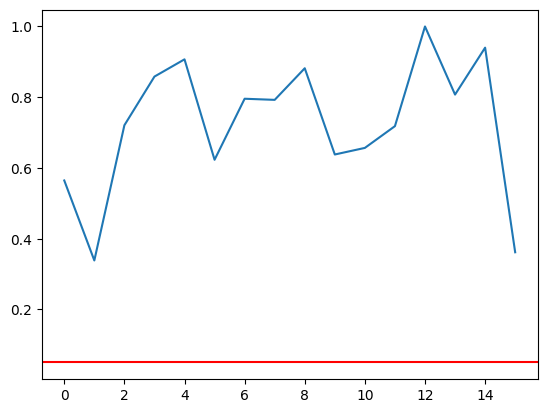

In [94]:
import matplotlib.pyplot as pp

pp.plot(pvals)
pp.axhline(y=0.05, color='r')
pp.show()

Да, на протяжении всего периода A/A-теста p-value не опускалось ниже уровня значимости, но очень сильно колебалось. Для чистоты эксперимента нам нужно не только устойчивое подтверждение $H_0$, но и равномерное распределение p-values, ведь, возможно, следующее колебание вмешается в результаты нашего теста.

Для проверки равномерности используем критерий Колмогорова-Смирнова

In [95]:
from scipy.stats import kstest

ks = kstest(pvals, "uniform", args=(0, 1))
ks

KstestResult(statistic=0.43958157458272984, pvalue=0.0024783531047605223, statistic_location=0.5645815745827298, statistic_sign=-1)

In [174]:
print("Распределение достаточно равномерно") if ks.pvalue > 0.05 else print("Распределение не равномерно")

Распределение не равномерно


Урежем выборки так, чтобы они удовлетворяли этому условию:

In [267]:
a1 = general[general.store_nbr.isin([53, 21, 52, 51, 29, 37, 26, 18, 17, 43])]
a2 = general[general.store_nbr.isin([9,  1, 22, 16, 47, 36, 23, 41, 32, 49])]
pvals = []
for date in a1.date.unique():
    a1_vals = a1[a1.date == date].onpromotion
    a2_vals = a2[a2.date == date].onpromotion
    pvals.append(stats.ttest_ind(a1_vals, a2_vals, equal_var=False).pvalue)
print("Распределение достаточно равномерно") if kstest(pvals, "uniform", args=(0, 1)).pvalue > 0.05 else print("Распределение не равномерно")

Распределение достаточно равномерно


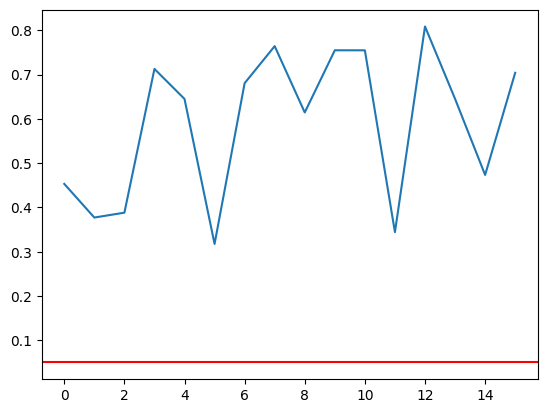

In [268]:
pp.plot(pvals)
pp.axhline(y=0.05, color='r')
pp.show()

Также две выборки должны быть **гомогенны** (однородны), то есть, должны принадлежать одному распределению:

In [276]:
kstest(a1_vals, a2_vals).pvalue > 0.05

True

И их распределение должно совпадать с распределением генеральной совокупности:

In [277]:
kstest(a1_vals, general.onpromotion).pvalue > 0.05, kstest(a2_vals, general.onpromotion).pvalue > 0.05

(True, True)

Нашли разбиение, для которого A/A-тест стабильно подтверждает нулевую гипотезу и выборки которого отражают распределение ГС. Можно переходить к знакомой процедуре A/B-теста.

## A/B/C-тесты

В некоторых ситуациях может понадобиться одновременно протестировать несколько гипотез.

Эксперимент: магазин одежды отправлял клиентам почтовую рассылку с рекламой женской одежды, мужской одежды или не отправлял рассылку вообще. Будем оценивать суммы, потраченные этими пользователями на сайте за год.

In [13]:
data = pd.read_csv("../data/MineThatData.csv")
data

,recency,history_segment,history,mens,womens,zip_code,newbie,channel,segment
0,10,2) $100 - $200,142.44,1,0,Surburban,0,Phone,Womens E-Mail
1,6,3) $200 - $350,329.08,1,1,Rural,1,Web,No E-Mail
2,7,2) $100 - $200,180.65,0,1,Surburban,1,Web,Womens E-Mail
3,9,5) $500 - $750,675.83,1,0,Rural,1,Web,Mens E-Mail
4,2,1) $0 - $100,45.34,1,0,Urban,0,Web,Womens E-Mail
...,...,...,...,...,...,...,...,...,...
63995,10,2) $100 - $200,105.54,1,0,Urban,0,Web,Mens E-Mail
63996,5,1) $0 - $100,38.91,0,1,Urban,1,Phone,Mens E-Mail
63997,6,1) $0 - $100,29.99,1,0,Urban,1,Phone,Mens E-Mail
63998,1,5) $500 - $750,552.94,1,0,Surburban,1,Multichannel,Womens E-Mail


Рассмотрим только группу клиентов из сельской местности (для неё более показательные результаты)

In [15]:
data = data[data.zip_code == 'Rural']

In [16]:
data['segment'].value_counts()

segment
Mens E-Mail      3243
Womens E-Mail    3181
No E-Mail        3139
Name: count, dtype: int64

In [17]:
data = data[['segment', 'history']]
data

,segment,history
1,No E-Mail,329.08
3,Mens E-Mail,675.83
8,Mens E-Mail,675.07
14,No E-Mail,241.42
17,Mens E-Mail,112.35
...,...,...
63949,No E-Mail,86.79
63951,Womens E-Mail,50.94
63952,No E-Mail,29.99
63958,Womens E-Mail,65.82


In [18]:
data.groupby('segment').history.mean()

segment
Mens E-Mail      238.224607
No E-Mail        250.424944
Womens E-Mail    240.102446
Name: history, dtype: float64

Растёт вероятность ошибки для независимых p-value, поэтому поднимается уровень значимости (false positive): $1 - (1 - \alpha)^n$, где n для A/B/.../N теста $n=\binom{N}{2}$

In [24]:
# слишком высокая альфа для настоящего эксперимента
alpha = 0.2
1 - (1 - alpha) ** 3

0.4879999999999999

Поправка Бонферрони: $\alpha* = \frac{\alpha}{n}$

In [25]:
bonferroni_alpha = alpha / 3
bonferroni_alpha

0.06666666666666667

Более чувствительная и более сложная поправка Бенджамини-Хохберга:<br>
1. Сортируем p-значения по возрастанию и присваиваем им индексы<br>
$p_1\leq p_2\leq ...\leq p_n$<br>
2. Находим p с наибольшим рангом $j*$ такое, что:<br>
$p_j\leq q$; $q = \gamma \frac{j}{n}$<br>
3. Все тесты с рангом $j < j*$ — статзначимые

Сравним результаты с двумя этими поправками.

In [26]:
def p(col1, col2):
    return ttest_ind(
        data[data.segment == col1].history.reset_index(drop=True),
        data[data.segment == col2].history.reset_index(drop=True), equal_var=False).pvalue

gamma = 0.1
segments = data.segment.unique()
df = pd.DataFrame(np.array(list(it.combinations(segments, 2))), columns=['seg1', 'seg2'])
df['p'] = df.apply(lambda x: p(x['seg1'], x['seg2']), axis=1)
df = df.sort_values(by=['p'])
df['q'] = gamma * (df.index + 1) / len(df)
df['p_corrected_BH'] = gamma * df['p'] ** len(df) / df['q']
df['BH'] = df['p_corrected_BH'] < alpha
df['bonferroni'] = df['p'] < bonferroni_alpha
df

,seg1,seg2,p,q,p_corrected_BH,BH,bonferroni
0,No E-Mail,Mens E-Mail,0.056732,0.033333,0.000548,True,True
1,No E-Mail,Womens E-Mail,0.107345,0.066667,0.001855,True,False
2,Mens E-Mail,Womens E-Mail,0.763290,0.100000,0.444702,False,False
